In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1203_0_8796.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1224_0_8188.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1212_0_3478.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1213_0_2794.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1219_0_4083.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1205_0_1825.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1243_0_9947.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1233_0_2605.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1208.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1200_0_7542.jpg
/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation/OC/oc_1219.jpg
/kaggle/input/teeth-disease/Teeth_D

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from PIL import Image

2025-07-02 19:55:15.047700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751486115.272864      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751486115.340095      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Training')
test_data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Testing')
validation_data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation')

Found 3087 files belonging to 7 classes.


2025-07-02 19:55:30.661767: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


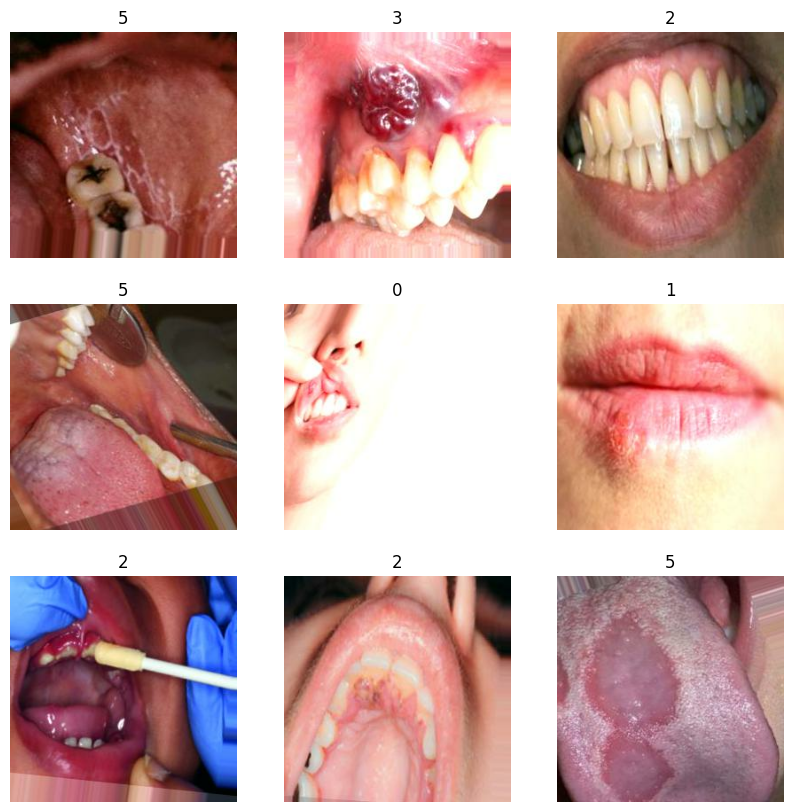

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [5]:
# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    rescale=1./255,                 # Scale images from [0, 255] to [0, 1]
    rotation_range=20,              # Rotate images by 20%
    width_shift_range=0.1,          # Shift images horizontally by 10%
    height_shift_range=0.1,         # Shift images vertically by 10%
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Zoom images by 20%
    horizontal_flip=True,           # Flip images horizontally
    fill_mode='nearest'             # Fill missing pixels after transformation
)

In [6]:
# Directory where augmented images will be saved
base_save_dir = 'Teeth_Dataset/Augmented'

# Ensure base directory exists
os.makedirs(base_save_dir, exist_ok=True)

# Iterate over the original dataset
for images, labels in train_data:
    for img, label in zip(images, labels):
        class_name = train_data.class_names[label.numpy()]  # Get the class name from the label
        save_dir = os.path.join(base_save_dir, class_name)  # Create subdirectory for the class
        os.makedirs(save_dir, exist_ok=True)  # Ensure the subdirectory exists
        
        # Save the augmented images into the class subdirectory
        i = 0
        for batch in datagen.flow(tf.expand_dims(img, 0), batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            i += 1
            if i > 10:  # Limit the number of new images per original image
                break
                

In [7]:
# load the augmented data
augmented_data = tf.keras.utils.image_dataset_from_directory('Teeth_Dataset/Augmented')

Found 26721 files belonging to 7 classes.


Scale Data

In [8]:
augmented_data = augmented_data.map(lambda x,y: (x/255, y))
test_data = test_data.map(lambda x,y: (x/255, y))
validation_data = validation_data.map(lambda x,y: (x/255, y))
# check if range is [0, 1]
for images, labels in augmented_data:
    print(images[0].numpy().min(), images[0].numpy().max())
    break

0.0 1.0


In [9]:
# Check for scaling and augmentation
for images, labels in augmented_data:
    print(images.shape, labels.shape)
    break


(32, 256, 256, 3) (32,)


In [10]:
train_data_iterator = augmented_data.as_numpy_iterator()
test_data_iterator = test_data.as_numpy_iterator()
validation_data_iterator =validation_data.as_numpy_iterator()
# Check if it is scaled from 0 to 1
print(train_data_iterator.next()[0].max())
print(train_data_iterator.next()[0].min())


1.0
0.0


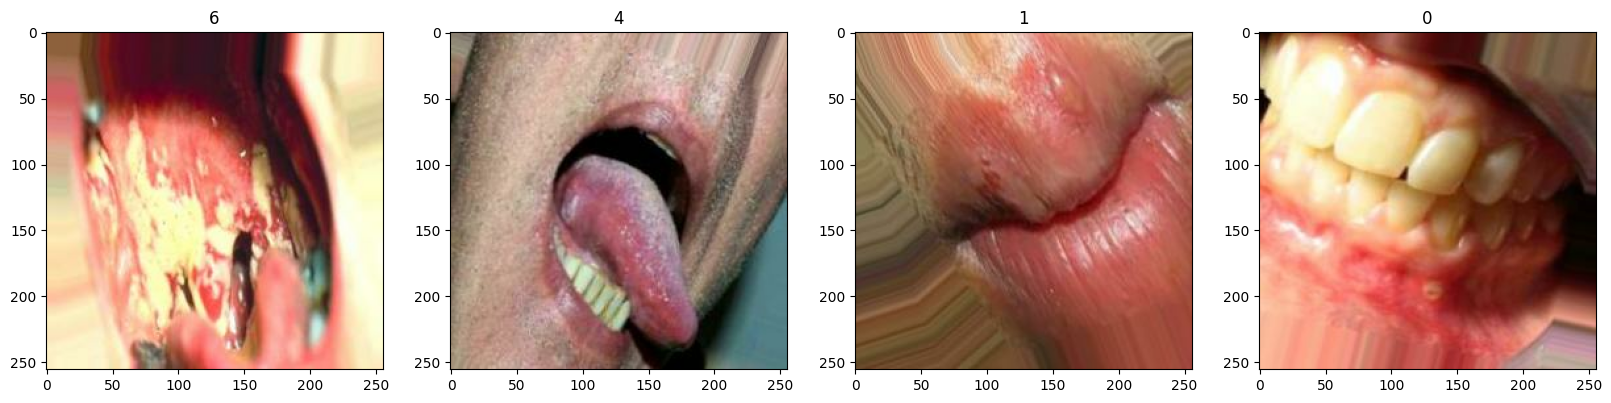

In [11]:
batch = train_data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Model

In [12]:
import tensorflow as tf

# Define input shape
input_shape = [256, 256, 3]

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1)
])

# Residual Block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    # First convolution
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Second convolution
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Adjust the shortcut dimensions if necessary
    if shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    
    # Add the shortcut
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Input layer
inputs = tf.keras.Input(shape=input_shape)

# Apply data augmentation
x = data_augmentation(inputs)

# Initial Convolution and MaxPooling
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(7, 7), strides=2, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
for filters in [16, 32, 64, 128]:
    x = residual_block(x, filters=filters)

# Global Average Pooling replaces Flatten
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Output Layer
outputs = tf.keras.layers.Dense(units=7, activation='softmax')(x)

# Create the model
Teeth_Disease = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Teeth_Disease.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Model summary
Teeth_Disease.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │          2,368 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 16)     │          2,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 16)     │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 64, 16)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 16)     │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 16)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 64, 16)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 32)     │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 345,479 (1.32 MB)

 Trainable params: 344,519 (1.31 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
Teeth_Disease.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
batch_size = 32

# Calculate steps per epoch
train_steps = len(augmented_data) // batch_size
val_steps = len(validation_data) // batch_size



model_history = Teeth_Disease.fit(
                              augmented_data,
                              validation_data=validation_data,
                              epochs=100,
                              steps_per_epoch=train_steps,
                              validation_steps=val_steps,
                                )

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.1762 - loss: 5.6895 - val_accuracy: 0.1875 - val_loss: 4.5997
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.2189 - loss: 4.2681 - val_accuracy: 0.1250 - val_loss: 3.6068
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.2611 - loss: 3.3261 - val_accuracy: 0.2188 - val_loss: 2.9973
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.3112 - loss: 2.7373 - val_accuracy: 0.2812 - val_loss: 2.5526
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.3131 - loss: 2.4065 - val_accuracy: 0.1875 - val_loss: 2.5633
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.3194 - loss: 2.2326 - val_accuracy: 0.2500 - val_loss: 2.3850
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.3573 - loss: 2.0630 - val_accuracy: 0.4688 - val_loss: 2.1424
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.2867 - loss: 2.1632 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 655ms/step - accuracy: 0.4873 - loss: 1.4693 - val_accuracy: 0.2812 - val_loss: 1.8540
Epoch 34/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.3588 - loss: 1.6778 - val_accuracy: 0.3125 - val_loss: 1.7212
Epoch 35/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.3282 - loss: 1.6777 - val_accuracy: 0.2188 - val_loss: 1.7155
Epoch 36/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.3693 - loss: 1.7155 - val_accuracy: 0.3438 - val_loss: 1.7877
Epoch 37/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.3749 - loss: 1.6621 - val_accuracy: 0.3125 - val_loss: 1.7112
Epoch 38/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.3487 - loss: 1.6443 - val_accuracy: 0.3125 - val_loss: 1.7229
Epoch 39/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.3965 - loss: 1.5994 - val_accuracy: 0.3438 - val_loss: 1.7741
Epoch 40/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.4206 - loss: 1.6384 - val_accuracy: 0.312

In [14]:
# Evaluate the model on the test dataset   
test_loss, test_accuracy = Teeth_Disease.evaluate(test_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 984ms/step - accuracy: 0.3499 - loss: 2.1021


In [15]:
# Save the model in the native Keras format
Teeth_Disease.save('Teeth_Disease_Model.keras')
import pickle
#Save the training history
with open('Teeth_Disease_History.pkl', 'wb') as f:
    pickle.dump(model_history.history, f)
# Save the preprocessing configuration
with open('preprocessing_config.pkl', 'wb') as f:
    pickle.dump({
        'rescale': 1./255,
        'rotation_range': 20,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
        'shear_range': 0.2,
        'zoom_range': 0.2,
        'horizontal_flip': True,
        'fill_mode': 'nearest'
    }, f)
# Load the augmented data
augmented_data = tf.keras.utils.image_dataset_from_directory(
    'Teeth_Dataset/Augmented',
    image_size=(256, 256),  # Use the same size as your model input
    batch_size=32,
    label_mode='int'
)

augmented_data = augmented_data.map(lambda x, y: (x / 255, y))

# Save the augmented data pipeline configuration
pipeline_config = {
    'image_size': (256, 256),
    'batch_size': 32
}

with open('augmented_data_pipeline_config.pkl', 'wb') as f:
    pickle.dump(pipeline_config, f)


Found 26721 files belonging to 7 classes.
